<a href="https://colab.research.google.com/github/nhathpham/Taxi-Fleet-Management/blob/main/trip_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load packages and data**

**Important**
Data dictionary here: https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data

## **0.1 Load packages**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import json

## **0.2 Load full taxi trip data**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your Parquet file
file_path = '/content/drive/My Drive/USML Projects/Data/sepnov.parquet'
raw = pd.read_parquet(file_path)  #1.69M records
#raw.head(1)

Mounted at /content/drive


## **0.3 Load Chicago geojson file with community area info**

In [ ]:
# File path
file_path = '/content/drive/My Drive/USML Projects/Nhat/chicago_ca.geojson'

# Read the GeoJSON file
with open(file_path, 'r') as f:
    geojson_data = json.load(f)

# Convert GeoJSON features to DataFrame
geojson_features = geojson_data['features']
geojson_df = pd.DataFrame([feature['properties'] for feature in geojson_features])
geojson_df['area_num_1'] = geojson_df['area_num_1'].astype(int)
geojson_df.head(2)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533


## **0.4 Region - community area mapping**
source: https://chicagocommunitygardens.org/communityareaslist/

In [ ]:
#The region mapping as from the above link
region_mapping = {
    'Far North Side': [1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 77, 76],
    'North Side': [5, 6, 7, 21, 22],
    'Northwest Side': [15, 16, 17, 18, 19, 20],
    'Central, Near North, and Near South Side': [8, 32, 33],
    'West and Near West Side': [23, 24, 25, 26, 27, 28, 29, 30, 31],
    'Southwest Side': [56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68],
    'South Side': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 69, 60],
    'Far Southwest Side': [70, 71, 72, 73, 74, 75],
    'Far South Side': [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
}

# Create a function to map area_num_1 to its region
def map_area_to_region(area_num):
    for region, areas in region_mapping.items():
        if area_num in areas:
            return region
    return None

# Apply the function to create the "region" column
geojson_df['region'] = geojson_df['area_num_1'].apply(map_area_to_region)

# Display the DataFrame
geojson_df.head(2)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,region
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,South Side
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,South Side


# **1. Remove columns, filter out records**
## **1.1 Remove columns**
- Census columns: lots of missing data
- Tolls: almost all records are 0 -> add this to extras


In [ ]:
print(len(raw))
# Remove census tract columns because of too much missing values
df = raw.drop(['pickup_census_tract', 'dropoff_census_tract'], axis=1)

# 0nly 8756 rows have tolls > 0
df['extras'] = df['extras']+df['tolls']
df = df.drop(['tolls'], axis=1)


1693017



## **1.2 Filter to trips that have pick up location inside the city only**
If these fields are *null*, the pickup and/or dropoff location is **outside of the city (Chicago)**: pickup_community_area, dropoff_community_area, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, pickup_location, dropoff_location
- If we impute these missing values with a common value, it will skew the clustering results
- If we create a binary variable (in city: 1, out of city: 0) we won't be able to use the spatial data

Hence, for now, let's remove rows with these nulls and just focus on trips that have pickup in the city. They can end in or outside of the city.


In [ ]:
# Remove trips that begin outside of the city
df = df[df.pickup_location.notnull()]
print(len(df))

1647832


## **1.3 Remove trips that look like they actually didn't happen (recording errors or cancellation)**

In [ ]:
# There are 29k records (1.7%) that have trip_seconds = 0, trip_miles = 0. Remove them assuming that these trips did not happen or there was metering issues
df = df[~((df.trip_miles==0.0)&(df.trip_seconds==0.0))]
print(len(df))

# Remove 12k trips that have trip_total <= 3.25 (base fare), pickup_location = dropoff_location, and trip_miles = 0 or trip_seconds = 0
df = df[~((df.trip_total<=3.25)&(df.pickup_community_area==df.dropoff_community_area)&((df.trip_miles==0.0)|(df.trip_seconds==0.0)))]
print(len(df))

1618934
1606008


## **1.4 trip_end_timestamps**
- Remove rows with missing trip_end_timestamp and zero trip_seconds and trip_miles = 0 or null, and trip_total = 0 or null

In [ ]:
# Conditions for rows to keep
remove_ts_condition = (
    df['trip_end_timestamp'].isnull() &  # Remove if trip_end_timestamp is missing and
    df['trip_seconds'].isnull() &  # trip_seconds is missing and
    (df['trip_miles'].isnull() | df['trip_miles'] == 0) &  # trip_miles is 0 or null and
    (df['trip_total'].isnull() | df['trip_total'] == 0) # trip_total is 0 or null
)
# Filter the DataFrame based on the condition
df = df[~remove_ts_condition]
len(df)

1605997

# **2. Correct data types**

In [ ]:
# Convert to datetime without considering 'UTC'
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'].str.slice(start=0, stop=-4), format='%Y-%m-%d %H:%M:%S')
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'].str.slice(start=0, stop=-4), format='%Y-%m-%d %H:%M:%S')
df['pickup_community_area'] = df['pickup_community_area'].astype('category')
df['dropoff_community_area'] = df['dropoff_community_area'].astype('category')
df['payment_type'] = df['payment_type'].astype('category')
df['company'] = df['company'].astype('category')
# The latitude and longitude columns can be combined to one single xolumn for pickup and drop off respectively.
df['pickup_location'] = df['pickup_latitude'].astype('string') + ", " + df['pickup_longitude'].astype('string')
df['dropoff_location'] = df['dropoff_latitude'].astype('string') + ", " + df['dropoff_longitude'].astype('string')
len(df)

1605997

# **3. Address missing values**

## **3.1 Impute missing community areas**
- Location (latitude, longitude) is the centroid of a census tract, or a community area. However, I notice that there are records with location but without a community area value.
- To address these, for any record with a non-null location but missing community area, I will determine the nearest location with a known community area and assign its community area to the entry with the missing information. Apply this to both pickup and drop-off location data.

In [ ]:
#round(df.isna().sum() / df.shape[0] *100,10)
#df.isna().sum()

- First, create a look up table for (longitude, latitude) and community area

In [ ]:
# Filter out entries with non-null community areas and non-null latitude/longitude.
pickup_notnull = df.dropna(subset=['pickup_community_area', 'pickup_latitude', 'pickup_longitude'])
dropoff_notnull = df.dropna(subset=['dropoff_community_area', 'dropoff_latitude', 'dropoff_longitude'])

# Combine unique pickup and dropoff locations into a single DataFrame for the lookup table.
# Ensure there are no duplicate latitude/longitude pairs.
lookup_df = pd.concat([
    pickup_notnull[['pickup_latitude', 'pickup_longitude', 'pickup_community_area']].rename(columns={
        'pickup_latitude': 'latitude',
        'pickup_longitude': 'longitude',
        'pickup_community_area': 'community_area'
    }),
    dropoff_notnull[['dropoff_latitude', 'dropoff_longitude', 'dropoff_community_area']].rename(columns={
        'dropoff_latitude': 'latitude',
        'dropoff_longitude': 'longitude',
        'dropoff_community_area': 'community_area'
    })
]).drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)

# Now, create a BallTree for efficient spatial queries.
# Convert latitude and longitude to radians for use with the BallTree.
lookup_df['latitude_rad'] = np.radians(lookup_df['latitude'])
lookup_df['longitude_rad'] = np.radians(lookup_df['longitude'])
tree = BallTree(lookup_df[['latitude_rad', 'longitude_rad']].values, metric='haversine')

# The lookup_df is your lookup table, and the BallTree 'tree' can be used for nearest-neighbor queries.
# Remember to drop the radian columns if you're going to save or use the lookup_df for other purposes.
lookup_df = lookup_df.drop(columns=['latitude_rad', 'longitude_rad'])

In [ ]:
def find_nearest_ca(tree, lookup_df, long_val, lat_val):
    # BallTree expects data in the form of [[latitude, longitude]]
    # Convert input longitude and latitude to radians
    lat_rad = np.radians(lat_val)
    long_rad = np.radians(long_val)

    # Query the tree for the nearest neighbor
    dist, idx = tree.query([[lat_rad, long_rad]], return_distance=True, k=1)

    # Get the community_area of the nearest neighbor
    nearest_community_area = lookup_df.iloc[idx[0][0]]['community_area']
    # Print the looked up longitude, latitude, and the found community area
    #print(f"Looking up coordinates: Longitude = {long_val}, Latitude = {lat_val}")
    #print(f"Nearest Community Area Found: {nearest_community_area}")
    return nearest_community_area

def fill_null_ca(tree, lookup_df, long_col, lat_col, ca_col, df):
    # Apply the find_nearest_ca function only to rows with null community areas
    mask = df[ca_col].isnull() & df[long_col].notnull() & df[lat_col].notnull()
    df.loc[mask, ca_col] = df.loc[mask].apply(
        lambda row: find_nearest_ca(tree, lookup_df, row[long_col], row[lat_col]), axis=1)
    return df

# Now you can call fill_null_ca function with the appropriate columns and DataFrame.
# Example usage:
df = fill_null_ca(tree, lookup_df, 'pickup_longitude', 'pickup_latitude', 'pickup_community_area', df)
df = fill_null_ca(tree, lookup_df, 'dropoff_longitude', 'dropoff_latitude', 'dropoff_community_area', df)
len(df)

1605997

**Now we dont have missing values for pickup_community_area**

In [ ]:
round(df.isna().sum() / df.shape[0] *100,10)
df.isna().sum()

unique_key                     0
taxi_id                        0
trip_start_timestamp           0
trip_end_timestamp             0
trip_seconds                 334
trip_miles                     5
pickup_community_area          0
dropoff_community_area    111399
fare                        4250
tips                        4250
extras                      4250
trip_total                  4250
payment_type                   0
company                        0
pickup_latitude                0
pickup_longitude               0
pickup_location                0
dropoff_latitude          111399
dropoff_longitude         111399
dropoff_location          111399
dtype: int64

## **3.2 Fare, Tips, Tolls, Extras, Trip_totals, Trip_seconds, Trip_miles**
- Impute missing fare and tolls with the median value of trips that share the same pickup_community_area, dropoff_community_area, and rounded trip_miles
- Impute missing trip duration (trip_seconds) with the median value of trips that share the same pickup_community_area, dropoff_community_area, and rounded trip_miles
- Impute missing trip distance (trip_miles) with the median value of trips that share the same pickup_community_area, dropoff_community_area, and rounded trip_seconds


In [ ]:
# Function to fill missing values for numerical columns
def fill_na_num(df, tofill_col, anchor_col='trip_miles'):
  # Calculate median fare values based on pickup_community_area, dropoff_community_area, and rounded trip_miles
  nonzero_miles = df[df[anchor_col] != 0]

  # Split the DataFrame based on null values in dropoff_community_area
  nonzero_miles_dropoff_null = nonzero_miles[nonzero_miles['dropoff_community_area'].isnull()]
  nonzero_miles_dropoff_notnull = nonzero_miles[nonzero_miles['dropoff_community_area'].notnull()]

  # Calculate median values for records with null dropoff_community_area
  median_vals_dropoff_null = nonzero_miles_dropoff_null.groupby(['pickup_community_area', nonzero_miles_dropoff_null[anchor_col].round()])[tofill_col].median()

  # Calculate median values for records with non-null dropoff_community_area
  median_vals_dropoff_notnull = nonzero_miles_dropoff_notnull.groupby(['pickup_community_area', 'dropoff_community_area', nonzero_miles_dropoff_notnull[anchor_col].round()])[tofill_col].median()

  filled_count = 0  # Counter for filled missing values
  # Fill missing fare values with median values based on pickup_community_area and dropoff_community_area
  for index, row in df[df[tofill_col].isnull()].iterrows():
    round_anchor = round(row[anchor_col])
    median_val = None  # Initialize

    if pd.isnull(row['dropoff_community_area']):
      median_val = median_vals_dropoff_null.get((row['pickup_community_area'], round_anchor))
      #print(f"Missing {tofill_col} for pickup_community_area {row['pickup_community_area']} with null dropoff, {anchor_col} {round_anchor}: Using median {median_val}")

    else:
      median_val = median_vals_dropoff_notnull.get((row['pickup_community_area'], row['dropoff_community_area'], round_anchor))
      #print(f"Missing {tofill_col} for pickup_community_area {row['pickup_community_area']}, dropoff_community_area {row['dropoff_community_area']} with {anchor_col} {round_anchor}: Using median {median_val}")

    # Check if median_val is NaN and try broader group or global median
    if pd.isnull(median_val):
      #print(f"No direct median found, using fallback strategy for {index}.")

      if pd.isnull(row['dropoff_community_area']):
        median_val = nonzero_miles[round(nonzero_miles['trip_miles']) == round_anchor][tofill_col].median()
        #print(f"Missing {tofill_col} for pickup_community_area {row['pickup_community_area']} with fallback strategy, trip_miles {round_anchor}: Using median {median_val}")

      else:
        median_val = nonzero_miles[(nonzero_miles['pickup_community_area'] == row['pickup_community_area']) & (nonzero_miles['dropoff_community_area'] == row['dropoff_community_area'])][tofill_col].median()
        #print(f"Missing {tofill_col} for pickup_community_area {row['pickup_community_area']}, dropoff_community_area {row['dropoff_community_area']} with {anchor_col} {round_anchor}: Using median {median_val}")

    # Fill the missing value in the dataframe
    df.at[index, tofill_col] = median_val
    filled_count += 1
  print(f"Filled missing '{tofill_col}' for {filled_count} rows")
  return df

df = fill_na_num(df, 'fare', anchor_col = 'trip_miles')
#df = fill_na_num(df, 'tolls', anchor_col = 'trip_miles')
df = fill_na_num(df, 'trip_seconds', anchor_col = 'trip_miles')
df = fill_na_num(df, 'trip_miles',anchor_col = 'trip_seconds')

Filled missing 'fare' for 4250 rows
Filled missing 'trip_seconds' for 334 rows
Filled missing 'trip_miles' for 5 rows


- Replace missing values for "extras" and "tips" with 0, as these amounts vary per trip and depend on information not available to us, such as customer satisfaction. The data dictionary specifies that cash tips are not recorded, justifying the assumption that unrecorded tips and extras can be considered as zero.

In [ ]:
# Fill missing values for extras and tips with zeros
df['extras'].fillna(0, inplace=True)
df['tips'].fillna(0, inplace=True)
df['trip_total'].fillna(df['fare'] + df['tips'] + df['extras'], inplace=True)
df = df[~((df.trip_miles==0)&(df.trip_seconds==0))]
len(df)

1605996

- **The only column with missing value are dropoff location-related columns** - we wont need these columns for analysis 1. Analysis 2+ might need them so think about imputing or removing later. *Imputing does not make a lot of sense here, because we don't have information on outside of Chicago*

In [ ]:
round(df.isna().sum() / df.shape[0] *100,10)
df.isna().sum()

unique_key                     0
taxi_id                        0
trip_start_timestamp           0
trip_end_timestamp             0
trip_seconds                   0
trip_miles                     0
pickup_community_area          0
dropoff_community_area    111399
fare                           0
tips                           0
extras                         0
trip_total                     0
payment_type                   0
company                        0
pickup_latitude                0
pickup_longitude               0
pickup_location                0
dropoff_latitude          111399
dropoff_longitude         111399
dropoff_location          111399
dtype: int64

# **4. Derive new variables**




In [ ]:
# Hour of day
df['hour'] = df['trip_start_timestamp'].dt.hour
# Day of Week
df['dow'] = df['trip_start_timestamp'].dt.day_name()
# 1 if weekend, 0 if not
df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
# Day of Week
df['month'] = df['trip_start_timestamp'].dt.month

# Define time periods
def assign_time_slot(hour):
    if 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 10:
        return 'Morning Rush'
    elif 10 <= hour < 13:
        return 'Midday'
    elif 13 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening Rush'
    elif 19 <= hour < 22:
        return 'Evening'
    #elif 22 <= hour <= 23 or hour == 0:
    #    return 'Late Evening'
    else:
        return 'Night'

df['period_start'] = df['hour'].apply(assign_time_slot)

# Get the total travel time in hours from the seconds column
df['trip_hours'] = np.where(df['trip_seconds'] == 0, 0.01, df['trip_seconds']) / 3600

# Get the Average speed from the miles and travel time in hours
df['avg_speed_mph'] = round(df['trip_miles'] / df['trip_hours'],4)

<ipython-input-14-c1dba8d0f426>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['trip_start_timestamp'].dt.hour


In [ ]:
important = ['trip_start_timestamp','trip_end_timestamp','trip_seconds','trip_miles','pickup_community_area','dropoff_community_area',
 'fare', 'tips','extras','trip_total','payment_type','company','pickup_latitude','pickup_longitude','pickup_location','dropoff_latitude','dropoff_longitude','dropoff_location','trip_hours']

# **6. Remove extreme outliers**

In [ ]:
#df.trip_total.hist()
#df_no_outlier2.trip_total.hist()
#df_no_outlier2.fare.hist()
#df_no_outlier3.trip_miles.hist()
#df_no_outlier5.avg_speed_mph.hist(bins=100)
len(df)

1605996

In [ ]:
print("Current length: ", len(df))

#trip_total
Q1 = df['trip_total'].quantile(0.10)
Q3 = df['trip_total'].quantile(0.90)
IQR = Q3 - Q1
filter = (df['trip_total'] >= Q1 - 1.5 * IQR) & (df['trip_total'] <= Q3 + 1.5 *IQR)
df_no_outlier = df.loc[filter]
print("Len after removing outlier trip_total: ", len(df_no_outlier))

#fare
Q1 = df['fare'].quantile(0.10)
Q3 = df['fare'].quantile(0.90)
IQR = Q3 - Q1

filter = (df['fare'] >= Q1 - 1.5 * IQR) & (df['fare'] <= Q3 + 1.5 *IQR)
df_no_outlier = df_no_outlier.loc[filter]
print("Len after removing outlier fare: ", len(df_no_outlier))

#trip_miles
Q1 = df['trip_miles'].quantile(0.10)
Q3 = df['trip_miles'].quantile(0.90)
IQR = Q3 - Q1
filter = (df['trip_miles'] >= Q1 - 1.5 * IQR) & (df['trip_miles'] <= Q3 + 1.5 *IQR)
df_no_outlier = df_no_outlier.loc[filter]
print("Len after removing outlier trip_miles: ", len(df_no_outlier))

#trip_seconds
Q1 = df['trip_seconds'].quantile(0.10)
Q3 = df['trip_seconds'].quantile(0.90)
IQR = Q3 - Q1
filter = (df['trip_seconds'] >= Q1 - 1.5 * IQR) & (df['trip_seconds'] <= Q3 + 1.5 *IQR)
df_no_outlier = df_no_outlier.loc[filter]
print("Len after removing outlier trip_seconds: ", len(df_no_outlier))

Current length:  1605996
Len after removing outlier trip_total:  1602113
Len after removing outlier fare:  1601430
Len after removing outlier trip_miles:  1601258
Len after removing outlier trip_seconds:  1597812


In [ ]:
df_no_outlier.sort_values('extras',ascending=False)[important].head(2)

NameError: name 'important' is not defined

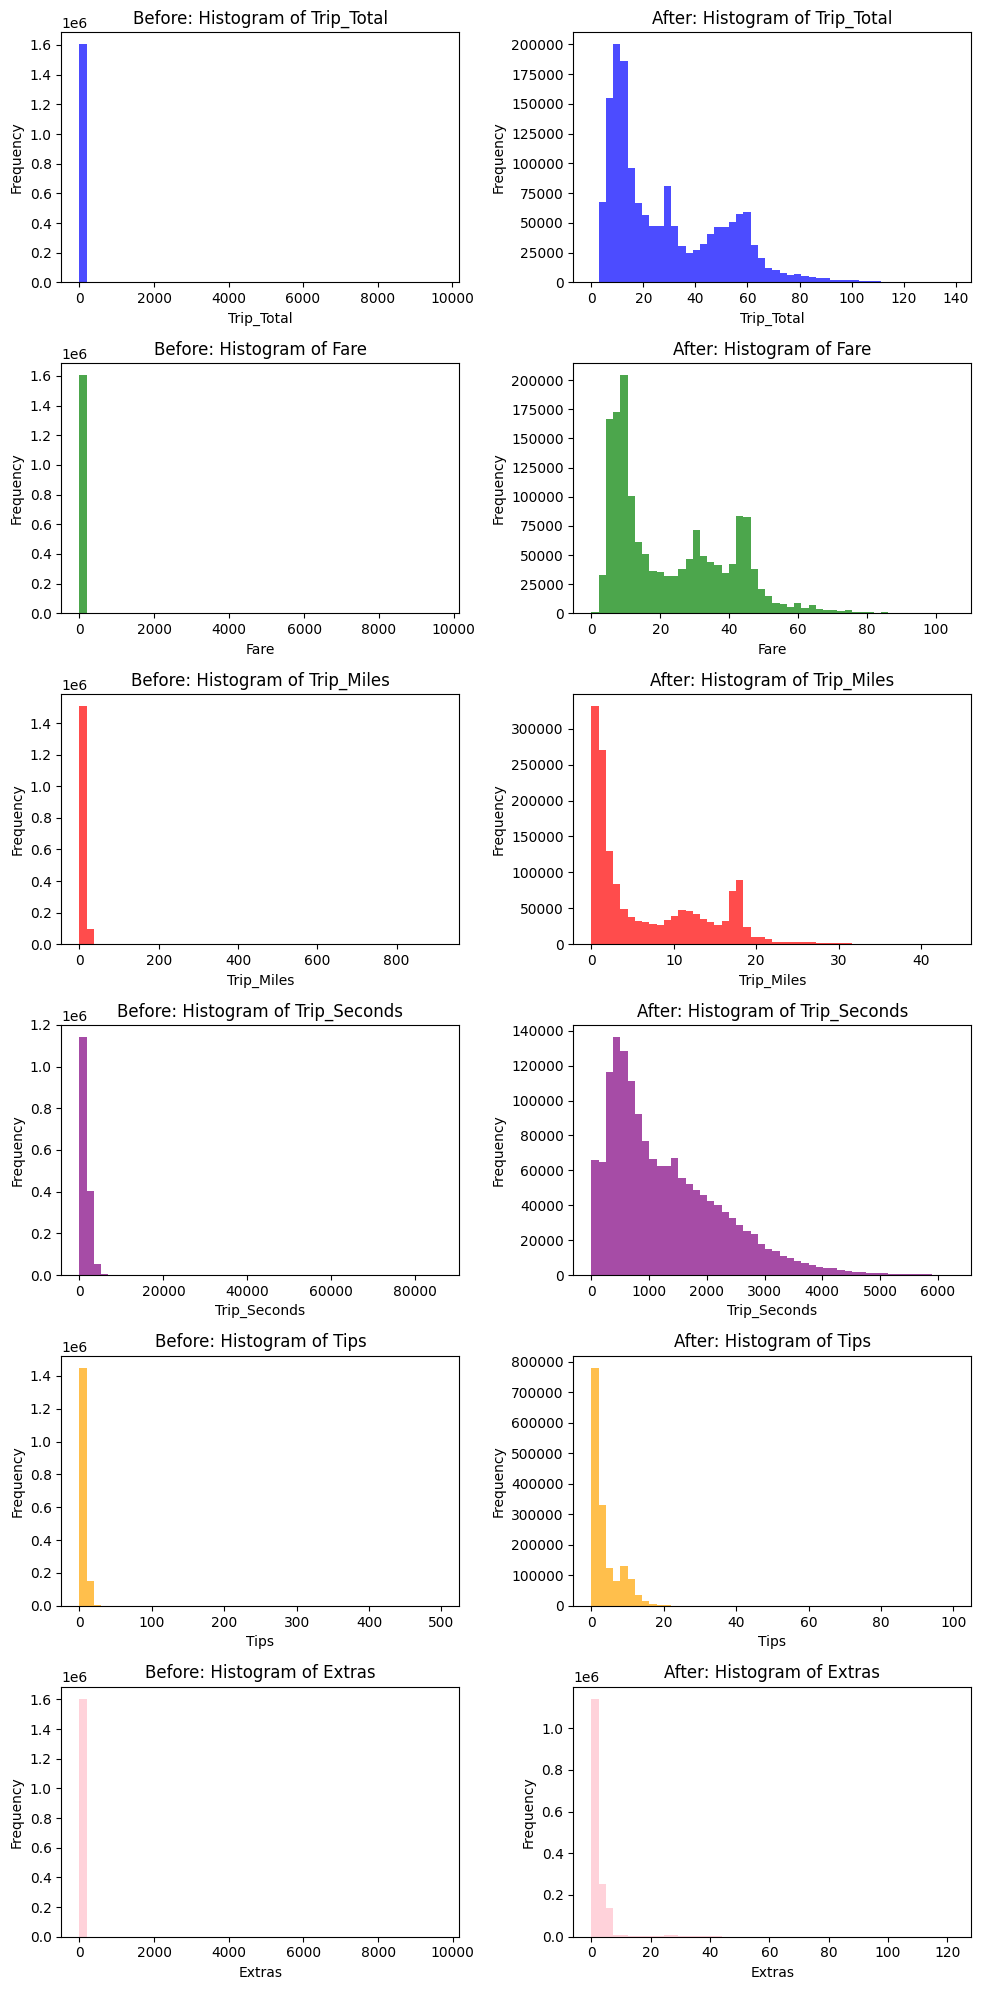

In [ ]:
# Create a figure with 6 subplots, each having 2 columns
fig, axs = plt.subplots(6, 2, figsize=(10,20))

# List of columns to plot
columns = ['trip_total', 'fare', 'trip_miles', 'trip_seconds', 'tips', 'extras']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink']

# Plot histogram for each column before and after removing outliers
for i, column in enumerate(columns):
    # Before removing outliers
    axs[i, 0].hist(df[column], bins=50, color=colors[i], alpha=0.7)
    axs[i, 0].set_title(f'Before: Histogram of {column.title()}')
    axs[i, 0].set_xlabel(column.title())
    axs[i, 0].set_ylabel('Frequency')

    # After removing outliers
    axs[i, 1].hist(df_no_outlier[column], bins=50, color=colors[i], alpha=0.7)
    axs[i, 1].set_title(f'After: Histogram of {column.title()}')
    axs[i, 1].set_xlabel(column.title())
    axs[i, 1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

# **7. Mark trips that potentially have recording errors**
After imputation and filtering efforts, there are still trips that seem like they did occur but there are meter recording errors. We create a new column to mark that. Specifically, rows with potentially recording-errored distance, duration, and cost.
- Cost-related anomalies: Checked trip_totals = sum(other costs) - no rows have difference > 4 so it is ok to leave as is
- Timestamp: there are some rows with trip_start_timestamp > trip_end_timestamp - these are the ones that have null trip_seconds -> we already dealt with them
- **Flag is_error = True for records with (df['avg_speed_mph'] < 1) or (df['avg_speed_mph'] > 80)** - this covers records with trip_miles = 0 or trip_records = 0

In [ ]:
df_no_outlier['record_error'] = (df_no_outlier['avg_speed_mph'] < 3) | (df_no_outlier['avg_speed_mph'] > 80)
df_no_outlier.record_error.sum()
#201695

201695

# **8. Get region names**

In [ ]:
geojson_df['area_num_1'] = geojson_df['area_num_1'].astype('float64').astype('category')
geojson_df['community'] = geojson_df['community'].str.title()
geojson_df['region'] = geojson_df['region'].str.replace('and', '&').str.replace('Side', '').str.strip()
geojson_df.area_num_1
geojson_df.head(2)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,region
0,Douglas,0,46004621.1581,0,35.0,35,0,0,31027.0545098,South
1,Oakland,0,16913961.0408,0,36.0,36,0,0,19565.5061533,South


In [ ]:
print(len(df_no_outlier))
# Selecting required columns from geojson_df
lookup_ca = geojson_df[['community', 'area_num_1', 'region']]

# Performing the left join
df_no_outlier = pd.merge(df_no_outlier, lookup_ca, how='left', left_on='pickup_community_area', right_on='area_num_1')
# Dropping the redundant 'area_num_1' column
df_no_outlier.drop(columns='area_num_1', inplace=True)
df_no_outlier.rename(columns={'region': 'pickup_region', 'community': 'pickup_ca_name'}, inplace=True)

# Performing the left join
df_no_outlier = pd.merge(df_no_outlier, lookup_ca, how='left', left_on='dropoff_community_area', right_on='area_num_1')
# Dropping the redundant 'area_num_1' column
df_no_outlier.drop(columns='area_num_1', inplace=True)
df_no_outlier.rename(columns={'region': 'dropoff_region', 'community': 'dropoff_ca_name'}, inplace=True)

print(len(df_no_outlier))

1597812
1597812


In [ ]:
df_no_outlier.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,...,is_weekend,month,period_start,trip_hours,avg_speed_mph,record_error,pickup_ca_name,pickup_region,dropoff_ca_name,dropoff_region
0,9e805296dc64928e9766a98bc9337fbf8b933d75,4c658dc5e7ea935f4c3bb9a3071f509efac3e99c93f6a6...,2023-10-06 09:30:00,2023-10-06 09:30:00,639.0,1.41,8.0,8.0,8.00,0.00,...,0,10,Morning Rush,0.177500,7.9437,False,Near North Side,"Central, Near North, & Near South",Near North Side,"Central, Near North, & Near South"
1,9d25380e55aec4162fb8cb6938e66c71f5599cc5,af54b850307713709ad002df059e2951e541401d6effc5...,2023-10-20 11:30:00,2023-10-20 11:30:00,509.0,1.66,8.0,32.0,7.75,2.00,...,0,10,Midday,0.141389,11.7407,False,Near North Side,"Central, Near North, & Near South",Loop,"Central, Near North, & Near South"
2,9adfb855a4e5465ebddeac182ee561a328eb0c86,a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b6...,2023-10-01 11:30:00,2023-10-01 12:00:00,1688.0,9.65,70.0,49.0,27.00,0.00,...,1,10,Midday,0.468889,20.5806,False,Ashburn,Far Southwest,Roseland,Far South
3,9a679dc37796cc45390cf13cf93ec1dc927eb35d,ebceb13997c9b897ffb47cbed8248f9a3de1c432e03f31...,2023-10-06 06:15:00,2023-10-06 06:30:00,1021.0,6.04,1.0,6.0,16.75,4.13,...,0,10,Early Morning,0.283611,21.2968,False,Rogers Park,Far North,Lake View,North
4,9fb21f2b4891a4575512aa647507d5ef1e91727e,ba0951d06c2db8c1623eaee9b2a34434c045baae41d5c7...,2023-10-08 10:15:00,2023-10-08 10:45:00,1008.0,10.54,37.0,48.0,27.75,0.00,...,1,10,Midday,0.280000,37.6429,False,Fuller Park,South,Calumet Heights,Far South


# **9. Save new dataframe**

In [ ]:
# Assuming df is your DataFrame
file_path = '/content/drive/My Drive/USML Projects/Data/clean_data_0213.parquet'  # Specify your path and file name
df_no_outlier.to_parquet(file_path, index=False)